### Copy past
Importing all previous code from the Julia source files by copy pasting. First we import the types.jl file

In [29]:
type LatticeSite
    A::Array{Float64,1}  # Fluctuating vector potential
    θ⁺::Float64 # Phase of the + component
    θ⁻::Float64 # Phase of the - component
    u⁺::Float64 # Amplitude of + component
end
type State
    lattice::Array{LatticeSite,2}  # Numerical lattice
    γ::Float64    # Order parameter amplitude
    g::Float64    # Gauge coupling
    ν::Float64    # Anisotropy constant
    f::Float64    # Magnetic filling fraction
end
#
#   Utility functions for the types
#
import Base.copya
function copy(ϕ::LatticeSite)
    LatticeSite([ϕ.A[1],ϕ.A[2]],ϕ.θ⁺,ϕ.θ⁻,ϕ.u⁺)
end
function copy(ψ::State)
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    lattice = [LatticeSite([ψ.lattice[y,x].A[1],ψ.lattice[y,x].A[2]],ψ.lattice[y,x].θ⁺,ψ.lattice[y,x].θ⁻,
            ψ.lattice[y,x].u⁺) for y = 1:Ly, x=1:Lx]
    State(lattice, ψ.γ, ψ.g, ψ.ν, ψ.f)
end

# -------------------------------------------------------------------------------------------------
# Outer constructor
# Initializes a state ψ that either 1: has zero as value for the the fluctuating gauge potential link variables,
# the phase and the u⁺ component (which means the u⁻=1) at each lattice site, or 2: has random values for
# these variables. The lattice in state ψ will consist of NxN lattice sites.
function State(N::Int64, choice::Int64)
    N <= 1 && throw(DomainError())
    
    # Constants
    γ = 1.0    # Order parameter amplitude
    g = 1.0    # Gauge coupling
    ν = 0.0    # Anisotropy constant
    f = 1.0/N    # Magnetic filling fraction
    
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
		lattice = [LatticeSite([rand(Uniform(-Amax,Amax)),rand(Uniform(-Amax,Amax))],
						   rand(Uniform(0,2π)), rand(Uniform(0,2π)), rand()) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end
# Same as above, but with possibility to initiate state constants
function State(N::Int64, choice::Int64, γ::Float64, g::Float64, ν::Float64, f::Float64)
    N <= 1 && throw(DomainError())
    
    # Construct ordered state 
    if choice == 1
        
        # Construct NxN lattice of NxN LatticeSites
        lattice = [LatticeSite([0,0],0,0,0) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # Construct random state
    elseif choice == 2
        Amax::Int64 = 2^10
		lattice = [LatticeSite([rand(Uniform(-Amax,Amax)),rand(Uniform(-Amax,Amax))],
						   rand(Uniform(0,2π)), rand(Uniform(0,2π)), rand()) for y=1:N, x=1:N]
        ψ = State(lattice, γ, g, ν, f)
        
    # We only have choices 1 and 2 so far so other values for choice will give an error.
    else
        throw(DomainError())
    end
    ψ
end

State

In [27]:
function test!(ψ::State, γ::Float64, g::Float64, ν::Float64, f::Float64)
    ψ.γ = γ
    ψ.g = g
    ψ.ν = ν
    ψ.f = f
    return
end
function test2!(ψ::State, constants::Tuple{Float64, Float64, Float64, Float64})
    (ψ.γ, ψ.g, ψ.ν, ψ.f) = constants
    return
end
ψ = State(40,2)
@benchmark test!(ψ, 4.0, 4.0, 0.3, 1.0/32)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     19.703 ns (0.00% GC)
  median time:      19.753 ns (0.00% GC)
  mean time:        19.821 ns (0.00% GC)
  maximum time:     46.606 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     997

In [28]:
@benchmark test2!(ψ, (4.0, 4.0, 0.3, 1.0/32))

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  1
  --------------
  minimum time:     20.586 ns (0.00% GC)
  median time:      21.444 ns (0.00% GC)
  mean time:        24.926 ns (10.40% GC)
  maximum time:     1.354 μs (94.12% GC)
  --------------
  samples:          10000
  evals/sample:     997

Then we import the functions.jl file

In [2]:
using Distributions

####################################################################################################################
#                            Energy functions
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Calculate energy contribution from a single term in the energy sum of the Higgs terms.
function fᵣ(ϕ::LatticeSite,ϕᵣ₊₁::LatticeSite,ϕᵣ₊₂::LatticeSite,A₀::Float64,γ::Float64,g::Float64,ν::Float64,f::Float64)
    energy = 0
    uᵣ₊₁⁻ = √(1-ϕᵣ₊₁.u⁺^2)
    u⁻ = √(1-ϕ.u⁺^2)
    uᵣ₊₂⁻ = √(1-ϕᵣ₊₂.u⁺^2)
    A₂ = ϕ.A[2]+A₀
    # Kinetic energy Fₖ
    energy += -2*γ^2*(ϕᵣ₊₁.u⁺ *ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁺ + g*ϕ.A[1]) 
        + ϕᵣ₊₂.u⁺*ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁺ + g*A₂) 
        + uᵣ₊₁⁻*u⁻*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁻ + g*ϕ.A[1]) 
        + uᵣ₊₂⁻*u⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁻ + g*A₂) )
    # Potential energy Fᵥ
    energy += γ^4*ϕ.u⁺^2*u⁻^2*(1+ν*cos(2*(ϕ.θ⁺-ϕ.θ⁻)))
    # Andreev Bashkin terms
    energy += γ^2*(ν+1)*(u⁻*ϕᵣ₊₂.u⁺*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ + g*A₂) 
        + ϕ.u⁺*uᵣ₊₂⁻*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ + g*A₂) 
        - u⁻*ϕᵣ₊₁.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ + g*ϕ.A[1]) 
        - ϕ.u⁺*uᵣ₊₁⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ + g*ϕ.A[1]))
    # Mixed gradient terms
    energy += γ^2*(ν-1)*(ϕᵣ₊₂.u⁺*uᵣ₊₁⁻*sin(ϕᵣ₊₁.θ⁻ - ϕᵣ₊₂.θ⁺ + g*(ϕ.A[1]-A₂)) 
        - uᵣ₊₂⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕᵣ₊₂.θ⁻ + g*(ϕ.A[1] - A₂)) 
        + 2*ϕ.u⁺*u⁻*sin(ϕ.θ⁻-ϕ.θ⁺) 
        -  u⁻*ϕᵣ₊₂.u⁺*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻ + g*A₂) 
        + ϕ.u⁺*uᵣ₊₂⁻*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺ + g*A₂) 
        + u⁻*ϕᵣ₊₁.u⁺*sin(ϕᵣ₊₁.θ⁺ - ϕ.θ⁻ + g*ϕ.A[1]) 
        - ϕ.u⁺*uᵣ₊₁⁻*sin(ϕᵣ₊₁.θ⁻ - ϕ.θ⁺ + g*ϕ.A[1]))
    energy
end

# -----------------------------------------------------------------------------------------------------------
# Loops over all positions of the lattice of a state and calculates the total energy from the
# Higgs-field terms using the function fᵣ() + the energy from the gauge field.
function E(ψ::State)
    γ = ψ.γ
    g = ψ.g
    energy = 0.0
    ν = ψ.ν
    f = ψ.f
    Lx = size(ψ.lattice,2)
    Ly = size(ψ.lattice,1)
    
    # Contribution from upper right corner
    A⁰ = (Lx-1)*2π*f
    ϕ = ψ.lattice[1,Lx]    # Lattice site at upper right corner
    ϕᵣ₊₁ = ψ.lattice[1,1]    # Nearest neighbor at r+x is upper left corner
    ϕᵣ₊₂ = ψ.lattice[Ly,Lx]  # Nearest neighbor at r+y is lower right corner
    energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
    energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2 # Maxwell term
    
    # Contribution from right boundary paralell to y-axis
    # except for the upper right corneϕ.
    for y=2:Ly
        ϕ = ψ.lattice[y,Lx]
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,Lx]
        A⁰ = (Lx-1)*2*π*f
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
    end
    
    # Contribution from the bulk of lattice sites and upper boundary
    for x=1:(Lx-1)
        A⁰ = (x-1)*2*π*f        # Constant vector potential.
        # Constribution from upper boundary except upper right corner
        ϕ = ψ.lattice[1,x]
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[Ly,x]
        energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
        energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
        
        # Contribution from the rest of the bulk.
        for y=2:Ly
            ϕ = ψ.lattice[y,x]          # Lattice site at position r
            ϕᵣ₊₁ = ψ.lattice[y,x+1]       # Nearest neighbor at r+x
            ϕᵣ₊₂ = ψ.lattice[y-1,x]       # Nearest neighbor at r+y
            
            energy += fᵣ(ϕ,ϕᵣ₊₁,ϕᵣ₊₂,A⁰,γ,g,ν,f)              # Higgs terms
            energy += (ϕ.A[1] + ϕᵣ₊₁.A[2]-ϕᵣ₊₂.A[1]-ϕ.A[2])^2
        end
    end
    
    energy
end

# -----------------------------------------------------------------------------------------------------------
# Find the energy difference between two states; one that has ϕ′ in position r with ϕᵣ... as neighbors,
# and one that has ϕ in position r. the position along the x-axis is needed for the constant Gauge field.
function ΔE(ψ::State, ϕ′::LatticeSite, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, 
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite, x::Int64)
    const g = ψ.g
    const δE::Float64 = 0.0
    
    # Calculate u⁻ for these lattice sites
    const u′⁻ = √(1-ϕ′.u⁺^2)
    const u⁻ = √(1-ϕ.u⁺^2)
    const u⁻ᵣ₊₁ = √(1-ϕᵣ₊₁.u⁺^2)
    const u⁻ᵣ₊₂ = √(1-ϕᵣ₊₂.u⁺^2)
    const u⁻ᵣ₋₁ = √(1-ϕᵣ₋₁.u⁺^2)
    const u⁻ᵣ₋₂ = √(1-ϕᵣ₋₂.u⁺^2)
    const u⁻ᵣ₋₁₊₂ = √(1-ϕᵣ₋₁₊₂.u⁺^2)
    const u⁻ᵣ₋₂₊₁ = √(1-ϕᵣ₋₂₊₁.u⁺^2)
    
    # Calculate constant link variables
    const A⁰ = 2π*ψ.f*(x-1)
    #const A⁰₊ = 2π*ψ.f*x
    const A⁰₋ = 2π*ψ.f*(x-2)
    
    # Normal kinetic terms
    δE += -2*ψ.γ^2*(ϕᵣ₊₁.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ′.θ⁺ + g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + g*ϕ.A[1]))
        + ϕᵣ₋₁.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₁*(u′⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ′.θ⁻ + g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ + g*ϕ.A[1]))
        + u⁻ᵣ₋₁*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + ϕᵣ₊₂.u⁺*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ′.θ⁺ + g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + g*(ϕ.A[2]+A⁰)))
        + ϕᵣ₋₂.u⁺*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)))
        + u⁻ᵣ₊₂*(u′⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ′.θ⁻ + g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ + g*(ϕ.A[2]+A⁰)))
        + u⁻ᵣ₋₂*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))))
    
    # Potential energy terms
    δE += ψ.γ^4*((ϕ′.u⁺*u′⁻)^2*(1+ψ.ν*cos(2*(ϕ′.θ⁺ - ϕ′.θ⁻))) - (ϕ.u⁺*u⁻)^2*(1+ψ.ν*cos(2*(ϕ.θ⁺ - ϕ.θ⁻))))
    
    # Andreev-Bashkin terms
    δE += ψ.γ^2*(ψ.ν+1)*(ϕᵣ₊₂.u⁺*(u′⁻*cos(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*cos(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        - ϕᵣ₊₁.u⁺*(u′⁻*cos(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*cos(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        + u⁻ᵣ₋₂*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - u⁻ᵣ₋₁*(ϕ′.u⁺*cos(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*cos(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]))
        + u⁻ᵣ₊₂*(ϕ′.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*cos(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        - u⁻ᵣ₊₁*(ϕ′.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*cos(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        + ϕᵣ₋₂.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        - ϕᵣ₋₁.u⁺*(u′⁻*cos(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*cos(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
    
    # Mixed gradient terms
    δE += ψ.γ^2*(ψ.ν-1)*(ϕᵣ₊₂.u⁺*u⁻ᵣ₊₁*(sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁻-ϕᵣ₊₂.θ⁺ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -ϕᵣ₊₂.u⁺*(u′⁻*sin(ϕᵣ₊₂.θ⁺-ϕ′.θ⁻+g*(ϕ′.A[2]+A⁰)) - u⁻*sin(ϕᵣ₊₂.θ⁺-ϕ.θ⁻+g*(ϕ.A[2]+A⁰))) 
        +ϕᵣ₊₁.u⁺*(u′⁻*sin(ϕᵣ₊₁.θ⁺-ϕ′.θ⁻+g*ϕ′.A[1]) - u⁻*sin(ϕᵣ₊₁.θ⁺-ϕ.θ⁻+g*ϕ.A[1])) 
        +u⁻ᵣ₋₂₊₁*(ϕ′.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ′.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - ϕ.u⁺*sin(ϕᵣ₋₂₊₁.θ⁻-ϕ.θ⁺+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +ϕᵣ₋₁₊₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁₊₂.θ⁺+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -u⁻ᵣ₋₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰)) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₂.θ⁻+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +u⁻ᵣ₋₁*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1]) - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁.θ⁻+g*ϕᵣ₋₁.A[1])) 
        -(u⁻ᵣ₊₂*ϕᵣ₊₁.u⁺*(sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ′.A[1] - (ϕ′.A[2]+A⁰))) 
            - sin(ϕᵣ₊₁.θ⁺-ϕᵣ₊₂.θ⁻ + g*(ϕ.A[1] - (ϕ.A[2]+A⁰)))) 
        -u⁻ᵣ₊₂*(ϕ′.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ′.θ⁺+g*(ϕ′.A[2]+A⁰)) - ϕ.u⁺*sin(ϕᵣ₊₂.θ⁻-ϕ.θ⁺+g*(ϕ.A[2]+A⁰))) 
        +u⁻ᵣ₊₁*(ϕ′.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ′.θ⁺+g*ϕ′.A[1]) - ϕ.u⁺*sin(ϕᵣ₊₁.θ⁻-ϕ.θ⁺+g*ϕ.A[1])) 
        +ϕᵣ₋₂₊₁.u⁺*(u′⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ′.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰))) 
            - u⁻*sin(ϕᵣ₋₂₊₁.θ⁺-ϕ.θ⁻+g*(ϕᵣ₋₂.A[1] - (ϕᵣ₋₂.A[2]+A⁰)))) 
        +u⁻ᵣ₋₁₊₂*(ϕ′.u⁺*sin(ϕ′.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋))) 
            - ϕ.u⁺*sin(ϕ.θ⁺-ϕᵣ₋₁₊₂.θ⁻+g*(ϕᵣ₋₁.A[1]-(ϕᵣ₋₁.A[2]+A⁰₋)))) 
        -ϕᵣ₋₂.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰)) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₂.θ⁺+g*(ϕᵣ₋₂.A[2]+A⁰))) 
        +ϕᵣ₋₁.u⁺*(u′⁻*sin(ϕ′.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1]) - u⁻*sin(ϕ.θ⁻-ϕᵣ₋₁.θ⁺+g*ϕᵣ₋₁.A[1])))
        +2*(ϕ′.u⁺*u′⁻*sin(ϕ′.θ⁻-ϕ′.θ⁺) - ϕ.u⁺*u⁻*sin(ϕ.θ⁻-ϕ.θ⁺)))
    
    # Then calculate the Gauge field contribution
    # First contribution from current position
    δE += (ϕ′.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ′.A[2])^2 - (ϕ.A[1] + ϕᵣ₊₁.A[2] - ϕᵣ₊₂.A[1] - ϕ.A[2])^2
    # Then from position r-x
    δE += (ϕᵣ₋₁.A[1] + ϕ′.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2 - (ϕᵣ₋₁.A[1] + ϕ.A[2] - ϕᵣ₋₁₊₂.A[1] - ϕᵣ₋₁.A[2])^2
    # Then from position r-y
    δE += (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ′.A[1] - ϕᵣ₋₂.A[2])^2 - (ϕᵣ₋₂.A[1] + ϕᵣ₋₂₊₁.A[2] - ϕ.A[1] - ϕᵣ₋₂.A[2])^2
end



####################################################################################################################
#                            Monte-Carlo functions
#
####################################################################################################################

# -----------------------------------------------------------------------------------------------------------
# Given a lattice site ϕ, propose a new lattice site with values in intervals around the existing ones.
function proposeLocalUpdate(ϕ::LatticeSite)
    const θmax = π/2 # How far away from the original value, the proposed new value for θ should be.
    const umax = 0.4 # How far away from the original value, the proposed amplitude u should be.
    const Amax = 3
    
    # Construct new configuration at lattice site.
    return LatticeSite([ϕ.A[1]+rand(Uniform(-Amax,Amax)), ϕ.A[2]+rand(Uniform(-Amax,Amax))],
        mod(ϕ.θ⁺ + rand(Uniform(-θmax,θmax)), 2π), mod(ϕ.θ⁻ + rand(Uniform(-θmax,θmax)), 2π), 
        mod(ϕ.u⁺ + rand(Uniform(-umax,umax)),1))
end

# -----------------------------------------------------------------------------------------------------------
# Performes a Metropolis Hasting update on a lattice site at position pos in state ψ given an inverse temperature
# β and where ϕᵣ... gives nearest and next nearest neighbor sites. Note that pos gives [y,x] of the position of
# the lattice site in normal array notation such that [1,1] is the upper left corner.
function metropolisHastingUpdate!(ψ::State, pos::Array{Int64,1}, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite,
        ϕᵣ₋₁::LatticeSite, ϕᵣ₋₂::LatticeSite, ϕᵣ₋₁₊₂::LatticeSite, ϕᵣ₋₂₊₁::LatticeSite, β::Float64)
	# Save the lattice site at the targeted position in a temporary variable ϕ and use the lattice site
	# as a basis for proposing a new lattice site ϕ′. Then find the energy difference between having
	# ϕ′ or ϕ at position pos.
    const ϕ = ψ.lattice[pos...]
    const ϕ′ = proposeLocalUpdate(ϕ)
    const δE = ΔE(ψ, ϕ′, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, pos[2])
    
    # Create random number ran ∈ (0,1].
    const ran = rand()
    if ran==0
        ran=1
    end
    
    # Update state with probability min(1, e^{-β⋅δE})
    # and return the energy of final state regardless of whether it gets updated or not.
    if log(ran) <= -β*δE
        ψ.lattice[pos...] = ϕ′
        return δE
    else
        return 0.0
    end
end

# -----------------------------------------------------------------------------------------------------------
# Takes a state ψ with an L×L lattice and tries to update each site on the lattice by running the
# metropolisHastingUpdate! function on it. Each part of the boundary is updated separately so that periodic
# boundary conditions are taken care of for values stored in each lattice site.
function mcSweep!(ψ::State, β::Float64)
   
    # Find size of the lattice L
    const L::Int64 = size(ψ.lattice,1)
    
    
    # Updating upper right corner
    const ϕᵣ₊₁ = ψ.lattice[1,1]
    const ϕᵣ₊₂ = ψ.lattice[L,L]
    const ϕᵣ₋₁ = ψ.lattice[1,L-1]
    const ϕᵣ₋₂ = ψ.lattice[2,L]
    const ϕᵣ₋₁₊₂ = ψ.lattice[L,L-1]
    const ϕᵣ₋₂₊₁ = ψ.lattice[2,1]
    metropolisHastingUpdate!(ψ, [1,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating boundary paralell to y-axis
    # except for the upper and lower right corner.
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,1]
        ϕᵣ₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₁ = ψ.lattice[y,L-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,L]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,1]
        metropolisHastingUpdate!(ψ, [y,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating lower right corner
    ϕᵣ₊₁ = ψ.lattice[L,1]
    ϕᵣ₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₁ = ψ.lattice[L,L-1]
    ϕᵣ₋₂ = ψ.lattice[1,L]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L-1]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,1]
    metropolisHastingUpdate!(ψ, [L,L], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating lower x-axis boundary except for lower left and right corner
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[L,x+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,x]
        ϕᵣ₋₁ = ψ.lattice[L,x-1]
        ϕᵣ₋₂ = ψ.lattice[1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[1,x+1]
        metropolisHastingUpdate!(ψ, [L,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating lower left corner
    ϕᵣ₊₁ = ψ.lattice[L,2]
    ϕᵣ₊₂ = ψ.lattice[L-1,1]
    ϕᵣ₋₁ = ψ.lattice[L,L]
    ϕᵣ₋₂ = ψ.lattice[1,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L-1,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[1,2]
    metropolisHastingUpdate!(ψ, [L,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating left y-axis boundary except corners
    for y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,2]
        ϕᵣ₊₂ = ψ.lattice[y-1,1]
        ϕᵣ₋₁ = ψ.lattice[y,L]
        ϕᵣ₋₂ = ψ.lattice[y+1,1]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,L]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,2]
        metropolisHastingUpdate!(ψ, [y,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # Updating upper left corner
    ϕᵣ₊₁ = ψ.lattice[1,2]
    ϕᵣ₊₂ = ψ.lattice[L,1]
    ϕᵣ₋₁ = ψ.lattice[1,L]
    ϕᵣ₋₂ = ψ.lattice[2,1]
    ϕᵣ₋₁₊₂ = ψ.lattice[L,L]
    ϕᵣ₋₂₊₁ = ψ.lattice[2,2]
    metropolisHastingUpdate!(ψ, [1,1], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    
    # Updating upper x-axis boundary
    for x=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[1,x+1]
        ϕᵣ₊₂ = ψ.lattice[L,x]
        ϕᵣ₋₁ = ψ.lattice[1,x-1]
        ϕᵣ₋₂ = ψ.lattice[2,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[L,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[2,x+1]
        metropolisHastingUpdate!(ψ, [1,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
    
    # This concludes the updates of the boundary
    
    # Update the bulk
    for x=2:(L-1), y=2:(L-1)
        ϕᵣ₊₁ = ψ.lattice[y,x+1]
        ϕᵣ₊₂ = ψ.lattice[y-1,x]
        ϕᵣ₋₁ = ψ.lattice[y,x-1]
        ϕᵣ₋₂ = ψ.lattice[y+1,x]
        ϕᵣ₋₁₊₂ = ψ.lattice[y-1,x-1]
        ϕᵣ₋₂₊₁ = ψ.lattice[y+1,x+1]
        metropolisHastingUpdate!(ψ, [y,x], ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₋₁, ϕᵣ₋₂, ϕᵣ₋₁₊₂, ϕᵣ₋₂₊₁, β)
    end
end


mcSweep! (generic function with 1 method)

In [3]:
using BenchmarkTools
ψ = State(40,2)
β = 1/4
mcSweep!(ψ, β)
ψ = State(40,2)
@benchmark mcSweep!(ψ,β)

BenchmarkTools.Trial: 
  memory estimate:  712.03 KiB
  allocs estimate:  25985
  --------------
  minimum time:     3.420 ms (0.00% GC)
  median time:      3.459 ms (0.00% GC)
  mean time:        3.928 ms (3.45% GC)
  maximum time:     14.206 ms (54.95% GC)
  --------------
  samples:          1272
  evals/sample:     1

# Calculation of Planar structure function of the local vorticity
This function is given by
$$ S^{(h)}(\mathbf{k}_\perp) = \frac{1}{(fL^3)^2}\Big\langle\Big|\sum_\mathbf{r}n_z^{(h)}(\mathbf{r})e^{i\mathbf{k}_\perp\cdot\mathbf{r}_\perp}\Big|^2\Big\rangle $$
where
$$ \mathbf{n}^{(h)}(\mathbf{r}) = \frac{1}{2\pi}\boldsymbol{\nabla}\times[\boldsymbol{\nabla}\theta^h - e\mathbf{A}]$$

I am curios whether passing by reference or passing by value makes a difference when calculating $n^{(h)}_z(\mathbf{r})$. Usually for most types in Julia, when passed as arguments to functions they are passed by reference, however types such as `Int64` and `Float64` are immutable and thus passed by value. Therefore when there immutable variables are passed as arguments, new variables has to be created each time a function is called.

In [30]:
const two_pi = 2π

# -----------------------------------------------------------------------------------------------------------
# Returns the local vorticity by preforming a plaquette sum using the gauge-invariant difference of the θ field.
function n⁺(ψ::State, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, x::Int64)
    return (mod(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + ψ.g*ϕ.A[1],two_pi) + mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺ + ψ.g*(ϕᵣ₊₁.A[2] + two_pi*ψ.f*x), two_pi) 
        - mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺ + ψ.g*ϕᵣ₊₂.A[1], two_pi) 
        - mod(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + ψ.g*(ϕ.A[2] + two_pi*ψ.f*(x-1)), two_pi))/two_pi
end
function n⁻(ψ::State, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, x::Int64)
    return (mod(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ + ψ.g*ϕ.A[1],two_pi) + mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻ + ψ.g*(ϕᵣ₊₁.A[2] + two_pi*ψ.f*x), two_pi) 
        - mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻ + ψ.g*ϕᵣ₊₂.A[1], two_pi) 
        - mod(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ + ψ.g*(ϕ.A[2] + two_pi*ψ.f*(x-1)), two_pi))/two_pi
end

# An altenative version that is a bad idea (depricated)
function n⁺2(Δ₁θ::Float64, Δ₂θᵣ₊₁::Float64, Δ₁θᵣ₊₂::Float64, Δ₂θ::Float64,
            Ax::Float64, Ay::Float64, Aᵣ₊₁y::Float64, Aᵣ₊₂x::Float64, g::Float64)
    return (mod(Δ₁θ + g*Ax, two_pi) + mod(Δ₂θᵣ₊₁ + g*Aᵣ₊₁y, two_pi) 
        - mod(Δ₁θᵣ₊₂ + g*Aᵣ₊₂x, two_pi) - mod(Δ₂θ + g*Ay, two_pi))/two_pi
end

# Another alternate version that has the added ability to also calculate vorticity of both helicity components.
function localVorticity(h::Int64, x::Int64, ψ::State, 
        ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite)
    if h == 1
        return (mod(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + ψ.g*ϕ.A[1],two_pi) + mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺ + ψ.g*(ϕᵣ₊₁.A[2] + two_pi*ψ.f*x), two_pi) 
        - mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺ + ψ.g*ϕᵣ₊₂.A[1], two_pi) 
        - mod(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + ψ.g*(ϕ.A[2] + two_pi*ψ.f*(x-1)), two_pi))/two_pi
    else
        return (mod(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻ + ψ.g*ϕ.A[1],two_pi) + mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻ + ψ.g*(ϕᵣ₊₁.A[2] + two_pi*ψ.f*x), two_pi) 
        - mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻ + ψ.g*ϕᵣ₊₂.A[1], two_pi) 
        - mod(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻ + ψ.g*(ϕ.A[2] + two_pi*ψ.f*(x-1)), two_pi))/two_pi
    end
end

localVorticity (generic function with 3 methods)

Testing the local vorticity for sensable output.

In [62]:
using Base.Test
# Creating state where there is no contribution from Gauge fields
ψ = State(2, 2, 4.0, 0.0, 1.0, 0.0)
ϕ = ψ.lattice[2,1]
ϕᵣ₊₁ = ψ.lattice[2,2]
ϕᵣ₊₂ = ψ.lattice[1,1]
ϕᵣ₊₁₊₂ = ψ.lattice[1,2]
# Setting phases manually
ϕ.θ⁺ = π/4
ϕᵣ₊₁.θ⁺ = 3π/4
ϕᵣ₊₂.θ⁺ = 3π/4
ϕᵣ₊₁₊₂.θ⁺ = 5π/4
println(@test n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 0) == 0)
ϕ.θ⁺ = π/4
ϕᵣ₊₁.θ⁺ = 3π/4
ϕᵣ₊₂.θ⁺ = 7π/4
ϕᵣ₊₁₊₂.θ⁺ = 5π/4
println(@test n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 0) == -1)
ϕ.θ⁺ = π/4
ϕᵣ₊₁.θ⁺ = -π/4
ϕᵣ₊₂.θ⁺ = -5π/4
ϕᵣ₊₁₊₂.θ⁺ = -3π/4
println(@test n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 0) == 1)

Test Passed
Test Passed
Test Passed


Checking that the two versions of the function gives the expected result and benchmarking which version runs fastest.

In [179]:
using BenchmarkTools
ψ = State(40, 2)
x1 = n⁺(ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2], 1)
x2 = localVorticity(1, 1, ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2])
println(x1 == x2)
@benchmark n⁺(ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2], 1)

true


BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     195.565 ns (0.00% GC)
  median time:      200.399 ns (0.00% GC)
  mean time:        204.263 ns (0.80% GC)
  maximum time:     4.579 μs (92.23% GC)
  --------------
  samples:          10000
  evals/sample:     616

In [180]:
@benchmark localVorticity(1, 1, ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2])

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     196.465 ns (0.00% GC)
  median time:      202.223 ns (0.00% GC)
  mean time:        203.680 ns (0.67% GC)
  maximum time:     14.086 μs (96.70% GC)
  --------------
  samples:          10000
  evals/sample:     202

In [8]:
using BenchmarkTools
ψ = State(2, 2)
# First evaluating by the first function
x1 = n⁺(ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2], 1)
# Evaluating by the second function we have to do some calculation in the call
x2 = n⁺2(ψ.lattice[2,2].θ⁺-ψ.lattice[2,1].θ⁺, ψ.lattice[1,2].θ⁺ - ψ.lattice[2,2].θ⁺, 
    ψ.lattice[1,2].θ⁺ - ψ.lattice[1,1].θ⁺, ψ.lattice[1,1].θ⁺ - ψ.lattice[2,1].θ⁺, 
    ψ.lattice[2,1].A[1], ψ.lattice[2,1].A[2] + two_pi*ψ.f*(1-1), 
    ψ.lattice[2, 2].A[2] + two_pi*ψ.f*(2-1), ψ.lattice[1,1].A[1], ψ.g)
println(x1==x2)
@benchmark n⁺(ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2], 1)

true


BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     194.968 ns (0.00% GC)
  median time:      196.675 ns (0.00% GC)
  mean time:        200.479 ns (0.32% GC)
  maximum time:     2.467 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     621

In [27]:
@benchmark n⁺2(ψ.lattice[2,2].θ⁺-ψ.lattice[2,1].θ⁺, ψ.lattice[1,2].θ⁺ - ψ.lattice[2,2].θ⁺, 
    ψ.lattice[1,2].θ⁺ - ψ.lattice[1,1].θ⁺, ψ.lattice[1,1].θ⁺ - ψ.lattice[2,1].θ⁺, 
    ψ.lattice[2,1].A[1], ψ.lattice[2,1].A[2] + two_pi*ψ.f*(1-1), 
    ψ.lattice[2, 2].A[2] + two_pi*ψ.f*(2-1), ψ.lattice[1,1].A[1], ψ.g)

BenchmarkTools.Trial: 
  memory estimate:  416 bytes
  allocs estimate:  26
  --------------
  minimum time:     941.519 ns (0.00% GC)
  median time:      960.259 ns (0.00% GC)
  mean time:        1.026 μs (1.66% GC)
  maximum time:     47.675 μs (93.05% GC)
  --------------
  samples:          10000
  evals/sample:     27

As expected, using many call by value arguments is a bad idea.

Now we want a function that calculates the pure structure function, i.e. not thermally averaged, since this will be taken care of by the Monte-Carlo simulation. The thought is using this function inside to monte-carlo simulation as an observable that we want to take the thermal average of. We thus don't need to divide by $(fL^2)^2$ each time we evaluate it and only need to calculate the sum over $\mathbf{r}$ at each measurement step.

In [66]:
# Finding the most efficient way of calculating complex numbers in Julia
cdot = rand()*2π
println(exp(im*cdot) == exp(Complex(0,cdot)) == cos(cdot) + im*sin(cdot))
@benchmark exp(im*cdot)

true


BenchmarkTools.Trial: 
  memory estimate:  64 bytes
  allocs estimate:  2
  --------------
  minimum time:     56.348 ns (0.00% GC)
  median time:      58.254 ns (0.00% GC)
  mean time:        66.505 ns (9.82% GC)
  maximum time:     2.979 μs (94.76% GC)
  --------------
  samples:          10000
  evals/sample:     984

In [67]:
@benchmark exp(Complex(0,cdot))

BenchmarkTools.Trial: 
  memory estimate:  64 bytes
  allocs estimate:  2
  --------------
  minimum time:     122.910 ns (0.00% GC)
  median time:      128.039 ns (0.00% GC)
  mean time:        135.300 ns (4.92% GC)
  maximum time:     3.148 μs (93.69% GC)
  --------------
  samples:          10000
  evals/sample:     909

In [159]:
@benchmark cos(cdot) + im*sin(cdot)

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  4
  --------------
  minimum time:     92.903 ns (0.00% GC)
  median time:      106.876 ns (0.00% GC)
  mean time:        153.168 ns (19.50% GC)
  maximum time:     15.792 μs (98.28% GC)
  --------------
  samples:          10000
  evals/sample:     949

Conclusion: using `im*cdot` seems to be significantly faster than other approaches.

In [172]:
# -----------------------------------------------------------------------------------------------------------
function structureFunctionPluss(k::Array{Int64,1}, ψ::State)
    sum = Complex(0)
    L = size(ψ.lattice, 2)
    
    # Sum over the corners
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
        
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    end
    
    # Sum over rest of the bulk
    for h_pos = 2:(L-1)
        for v_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    
    return abs2(sum)
end

# In light of new realization that we have a lot of cancellation going on along the rows of the lattice
# it would make more sense to try and calculate along rows first.
# Tried this and it didn't matter. Probably made it a bit slower.
function structureFunctionPluss2(k::Array{Int64,1}, ψ::State)
    sum = Complex(0)
    L = size(ψ.lattice, 2)
    
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
    end
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    for i = 2:(L-1)
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
    end
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    end
    
    # Sum over rest of the bulk
    for v_pos = 2:(L-1)
        for h_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    
    for i = 2:(L-1)
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    end
        
    return abs2(sum)
end
# If we assume k = 0, then we don't need to use complex numbers.
function structureFunctionPluss(ψ::State)
    sum = 0.0
    L = size(ψ.lattice, 2)
    
    # Sum over the corners
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)
        
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)
        
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)
        
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)
    end
    
    # Sum over rest of the bulk
    for h_pos = 2:(L-1)
        for v_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)
        end
    end
    
    return sum^2
end



structureFunctionPluss (generic function with 2 methods)

In [176]:
# -----------------------------------------------------------------------------------------------------------
# These versions should do the same as above, but determines the neighbors dynamically.
function structureFunctionPlussDyn(k::Array{Int64,1}, ψ::State)
    L = size(ψ.lattice, 1)
    sum = Complex(0.0)
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    return abs2(sum)
end
# What if we where to sum the real part and imaginary part separately?
function structureFunctionPlussDyn2(k::Array{Int64,1}, ψ::State)
    L = size(ψ.lattice, 1)
    sumRe = 0.0
    sumIm = 0.0
    n = 0.0
    dot = 0.0
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            n = n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)
            dot = k⋅r
            sumRe += n*cos(dot)
            sumIm += n*sin(dot)
        end
    end
    return sumRe^2 + sumIm^2
end
# In the second version we assume that k = 0
function structureFunctionPlussDyn(ψ::State)
    L = size(ψ.lattice, 1)
    sum = 0.0
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)
        end
    end
    return sum^2
end

structureFunctionPlussDyn (generic function with 2 methods)

In [116]:
# Helping function for calculating position vector in [x,y] format from a lattice position
# assuming origo is in lower left corner of the square lattice. L is the size of the lattice along one dimension.
function getVectorPosition(L::Int64, pos::Array{Int64,1})
    v_pos = pos[1]
    h_pos = pos[2]
    return [h_pos-1, L-v_pos]
end

getVectorPosition (generic function with 1 method)

### Tests for these functions.
Do they calculate what we want?

In [178]:
# First the zero test. If we set everything to 0 do we get 0 in the end?
ψ = State(30, 1)
L = size(ψ.lattice,1)
ψ.f = 0
k = [rand(1:L)-1, rand(1:L)-1]
println(@test structureFunctionPluss(k, ψ) == 0)

# Even if we create a local vortex at [L-1,2], the sum should be zero still if k=0
ψ.lattice[L-1, 3].θ⁺ = π/2
ψ.lattice[L-2, 3].θ⁺ = π
ψ.lattice[L-2, 2].θ⁺ = 3π/2
println(@test n⁺(ψ,ψ.lattice[L-1,2],ψ.lattice[L-1,3],ψ.lattice[L-2,2],ψ.lattice[L-2,3], 2) == -1)
println(@test structureFunctionPluss([0,0], ψ) == 0)

# For a general k, we will get the expression
# Note that the order of the terms in the sum is important for getting the same floating point value.
res = 0.0
res -= exp(im*(k⋅getVectorPosition(L,[L,3])))
res += exp(im*(k⋅getVectorPosition(L,[L-2, 1])))
res += exp(im*(k⋅getVectorPosition(L,[L-2, 2])))
res -= exp(im*(k⋅getVectorPosition(L,[L-1,2])))
res = abs2(res)
println(@test structureFunctionPluss(k, ψ) == res)

# Finally we want to turn on the static part of the gauge field and make sure that this normalizes correctly
# when k = 0, given that all phases are again zero.
ψ = State(30,1)
ψ.f = 1/(2*L)
ψ.g = 1
println(@test structureFunctionPluss([0,0], ψ) == (ψ.f*L^2)^2)

Test Passed
Test Passed
Test Passed
Test Passed
Test Failed
  Expression: structureFunctionPluss([0, 0], ψ) == (ψ.f * L ^ 2) ^ 2
   Evaluated: 225.0000000000097 == 225.0


LoadError: [91mThere was an error during testing[39m

In [77]:
ψ = State(40,2)
ψ.f = 100
@show structureFunctionPluss([0,0], ψ)
@show structureFunctionPluss(ψ)
@show structureFunctionPlussDyn([0,0], ψ)
@show structureFunctionPlussDyn2([0,0], ψ)
@show structureFunctionPlussDyn(ψ)
@benchmark structureFunctionPlussDyn([0,0], ψ)

structureFunctionPluss([0, 0], ψ) = 2.2027227176427983e-22
structureFunctionPluss(ψ) = 2.2027227176427983e-22
structureFunctionPlussDyn([0, 0], ψ) = 2.2027556726768925e-22
structureFunctionPlussDyn2([0, 0], ψ) = 2.2027556726768925e-22
structureFunctionPlussDyn(ψ) = 2.2027556726768925e-22


BenchmarkTools.Trial: 
  memory estimate:  150.11 KiB
  allocs estimate:  1602
  --------------
  minimum time:     489.078 μs (0.00% GC)
  median time:      493.551 μs (0.00% GC)
  mean time:        520.485 μs (4.16% GC)
  maximum time:     4.114 ms (84.61% GC)
  --------------
  samples:          9583
  evals/sample:     1

In [78]:
@benchmark structureFunctionPlussDyn2([0,0], ψ)

BenchmarkTools.Trial: 
  memory estimate:  150.11 KiB
  allocs estimate:  1602
  --------------
  minimum time:     486.505 μs (0.00% GC)
  median time:      491.409 μs (0.00% GC)
  mean time:        518.548 μs (4.21% GC)
  maximum time:     6.402 ms (88.67% GC)
  --------------
  samples:          9620
  evals/sample:     1

In [79]:
@benchmark structureFunctionPlussDyn(ψ)

BenchmarkTools.Trial: 
  memory estimate:  150.02 KiB
  allocs estimate:  1601
  --------------
  minimum time:     464.952 μs (0.00% GC)
  median time:      470.285 μs (0.00% GC)
  mean time:        496.746 μs (4.46% GC)
  maximum time:     4.009 ms (84.69% GC)
  --------------
  samples:          10000
  evals/sample:     1

Conclusion: It seems that, calculating real and imaginary part separately or using the native Julia complex type is comparable.

#### Next question is whether using the explicit evaluaring has any value compared to determining neighbors dynamically

In [103]:
using Plots
gr()
# We want to see how the difference in performance changes with lattice size
sizes = [10, 15, 20, 30, 40]
M = size(sizes,1)
m1 = zeros(M)
s1 = zeros(M)
m2 = zeros(M)
s2 = zeros(M)

for i=1:M
    ψ = State(sizes[i],2)
    t1 = @benchmark structureFunctionPluss([0,0],$ψ)
    m1[i] = mean(t1).time
    s1[i] = std(t1.times)/sqrt(size(t1.times,1))
    t2 = @benchmark structureFunctionPlussDyn([0,0],$ψ)
    m2[i] = mean(t2).time
    s2[i] = std(t2.times)/sqrt(size(t2.times,1))
end
@show m1
@show s1
@show m2
@show s2

m1 = [16438.8, 49739.1, 1.03636e5, 2.47593e5, 4.44887e5]
s1 = [1204.3, 1769.38, 2368.14, 3589.95, 4909.17]
m2 = [20014.3, 57370.1, 1.16646e5, 2.76848e5, 6.14242e5]
s2 = [1205.96, 1789.13, 2380.76, 3619.54, 9100.88]


5-element Array{Float64,1}:
 1205.96
 1789.13
 2380.76
 3619.54
 9100.88

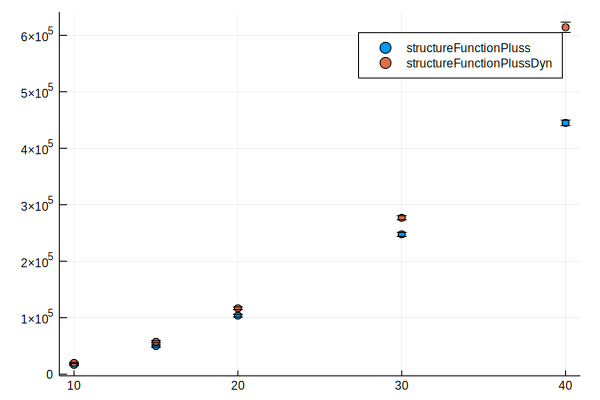

In [104]:
scatter(sizes, m1, err=s1, label="structureFunctionPluss")
scatter!(sizes, m2, err=s2, label="structureFunctionPlussDyn")

Conclusion: The function with explicit evalustion is faster than the dynamic function and the difference gets larger at larger lattice sizes as expected